# Oct 6th, 2022 (Python processed)

**Motivation**: Edited xtract.m (previously: hadi_processed.m) used to extract data from designstructs (Yuwei's directory).  Next, wrote a function mat2hypy to extract data from MATLAB files and save as h5. <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.vae import ConfigVAE, VAE
from utils.plotting import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## From MATLAB to h5py

In [2]:
from utils.process import mat2hypy

base_dir = '/home/hadi/Documents/MTMST'
xtract_dir = pjoin(base_dir, 'Yuwei', 'MTproject_data', 'xtracted')
save_dir = pjoin(base_dir, 'MTLFP', 'xtracted_python')
os.makedirs(save_dir, exist_ok=True)

In [3]:
mat2hypy(load_dir=xtract_dir, save_dir=save_dir, tres=25, grd=15)

group ytu029 created: 100%|██████████| 60/60 [02:20<00:00,  2.34s/it]


DONE.

### Check one of the mat files

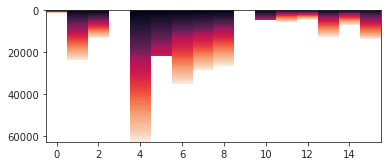

In [3]:
import scipy.io as sio
f = 'tres25_clu221.mat'
mat_content = sio.loadmat(pjoin(xtract_dir, f))
list(mat_content)

['__header__',
 '__version__',
 '__globals__',
 'badspks',
 'badspksR',
 'cellindex',
 'centerx',
 'centerxR',
 'centery',
 'centeryR',
 'expt_name',
 'field',
 'fix_lost_all',
 'fixlost',
 'fixlostR',
 'latency',
 'lfp',
 'lfpR',
 'num_channels',
 'nx',
 'ny',
 'opticflows',
 'opticflowsR',
 'partition',
 'partitionR',
 'psth_raw_all',
 'repeats',
 'rf_loc',
 'spatres',
 'spks',
 'spksR',
 'spkst',
 'spkstR',
 'stim1',
 'stim2',
 'stimR',
 'tind_start_all']

In [4]:
from utils.process import _fix_spkst, _fix_stim
spkst = _fix_spkst(mat_content['spkstR'])
spkst.shape

(11763, 16)

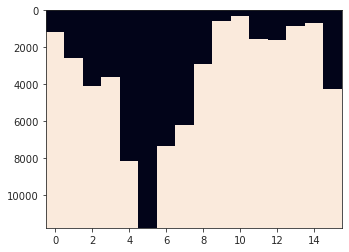

In [5]:
plt.imshow(np.isnan(spkst), aspect=1/1000)

## Hyperflow

In [6]:
t = 512
opf = np.round(mat_content['opticflows'][t], 4)
opf

array([13.049 , 13.2802, -3.2637, -3.079 ,  1.301 ,  1.6489])

In [7]:
cx = mat_content['centerx'][t].item()
cy = mat_content['centery'][t].item()
cx, cy

(3.0664302816466473, 0.5885076891866451)

In [12]:
size = (32,) * 2
sres = 2
radius = 7

xl = int(np.round(size[0] / sres))
yl = int(np.round(size[1] / sres))

xi0 = np.linspace(- xl / 2 + 0.5, xl / 2 - 0.5, xl) * sres
yi0 = np.linspace(- yl / 2 + 0.5, yl / 2 - 0.5, yl) * sres
xi0, yi0 = np.meshgrid(xi0, yi0)

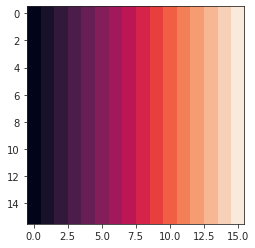

In [13]:
plt.imshow(xi0)

In [14]:
xi = xi0 - cx
yi = yi0 - cy
mask = xi**2 + yi**2 <= radius**2
raw = np.zeros((xl, yl, 2, 6))

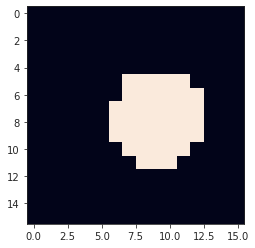

In [15]:
plt.imshow(mask)

In [16]:
from utils.hyperflow import get_vel_field

In [17]:
center = np.concatenate([
    mat_content['centerx'].reshape(-1, 1),
    mat_content['centery'].reshape(-1, 1)
], axis=-1)

In [18]:
stim = get_vel_field(
    opticflow=mat_content['opticflows'].astype(float),
    center=center,
    size=size,
    sres=sres,
    radius=7,
)
stim.shape

(43200, 512)

In [19]:
def fix_stim2(x, grd):
    return x.reshape((-1, grd, grd, 2))

In [21]:
x = fix_stim2(stim, 16)
x.shape

(43200, 16, 16, 2)

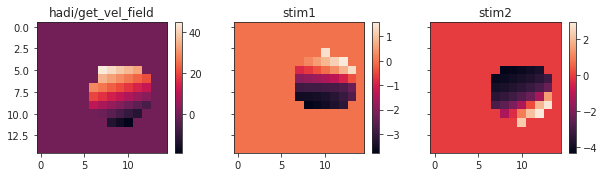

In [51]:
fig, axes = create_figure(1, 3, (10, 2.4), 'all', 'all', constrained_layout=False)
im = axes[0].imshow(x[t, ..., 1])
plt.colorbar(im, ax=axes[0])
axes[0].set_title('hadi/get_vel_field')

im = axes[1].imshow(_fix_stim(mat_content['stim1'], 15)[t, ..., 1])
plt.colorbar(im, ax=axes[1])
axes[1].set_title('stim1')

im = axes[2].imshow(_fix_stim(mat_content['stim2'], 15)[t, ..., 1])
plt.colorbar(im, ax=axes[2])
axes[2].set_title('stim2')

plt.show()

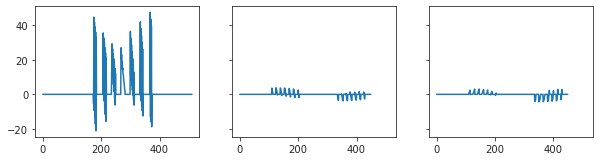

In [66]:
fig, axes = create_figure(1, 3, (10, 2.4), 'all', 'all', constrained_layout=False)
axes[0].plot(stim[t])
axes[1].plot(mat_content['stim1'][t])
axes[2].plot(mat_content['stim2'][t])
plt.show()

In [53]:
y = mat_content['spks'].astype(float)
z = np.einsum('ij, jklm -> iklm ', y.T, x)
z /= np.max(np.abs(z))
z.shape

(16, 16, 16, 2)

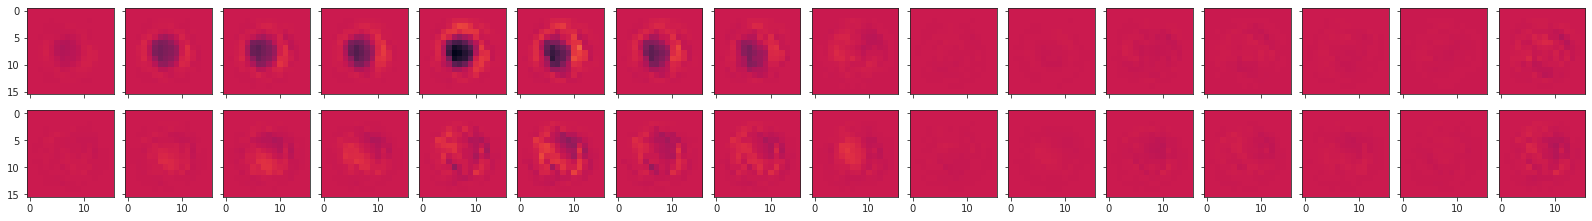

In [54]:
fig, axes = create_figure(2, 16, (22, 3), 'all', 'all', constrained_layout=True)

for i in range(16):
    axes[0, i].imshow(z[i, ..., 0], vmin=-1, vmax=1)
    axes[1, i].imshow(z[i, ..., 1], vmin=-1, vmax=1)
plt.show()

In [57]:
y = mat_content['spks'].astype(float)
z = np.einsum('ij, jklm -> iklm ', y.T, _fix_stim(mat_content['stim1'], 15))
z /= np.max(np.abs(z))
z.shape

(16, 15, 15, 2)

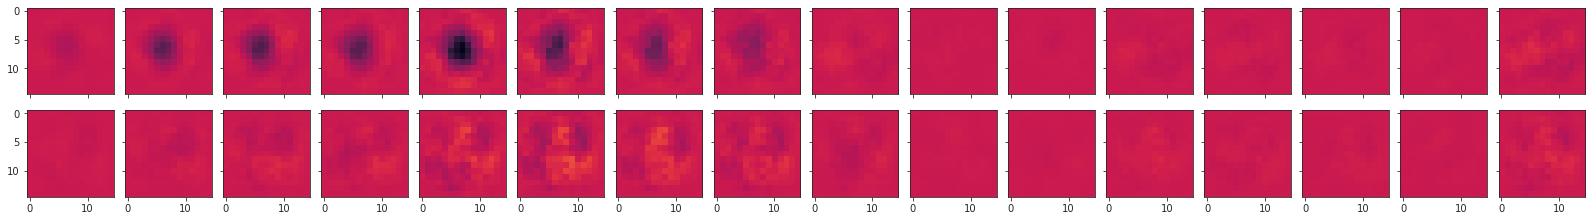

In [58]:
fig, axes = create_figure(2, 16, (22, 3), 'all', 'all', constrained_layout=True)

for i in range(16):
    axes[0, i].imshow(z[i, ..., 0], vmin=-1, vmax=1)
    axes[1, i].imshow(z[i, ..., 1], vmin=-1, vmax=1)
plt.show()

In [59]:
y = mat_content['spks'].astype(float)
z = np.einsum('ij, jklm -> iklm ', y.T, _fix_stim(mat_content['stim2'], 15))
z /= np.max(np.abs(z))
z.shape

(16, 15, 15, 2)

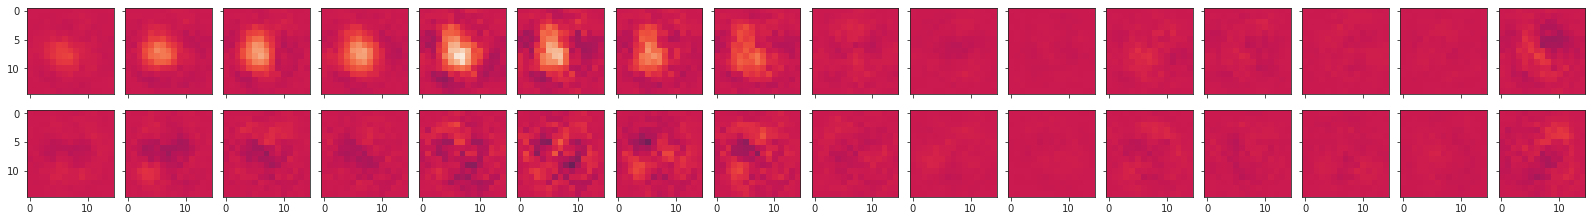

In [60]:
fig, axes = create_figure(2, 16, (22, 3), 'all', 'all', constrained_layout=True)

for i in range(16):
    axes[0, i].imshow(z[i, ..., 0], vmin=-1, vmax=1)
    axes[1, i].imshow(z[i, ..., 1], vmin=-1, vmax=1)
plt.show()

In [67]:
df = []
for i in range(16):
    num = y[:, i].sum(0)
    df.append({
        'cell': [i],
        'num_spk': [num],
        'fr': [num / (len(y) * 25e-3)],
    })
df = pd.DataFrame(merge_dicts(df))

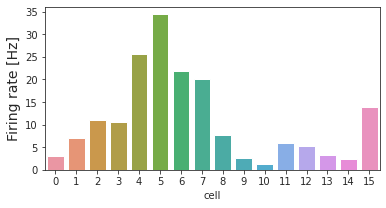

In [68]:
fig, ax = create_figure(1, 1, (6, 3))
sns.barplot(data=df, x='cell', y='fr', ax=ax)
ax.set_ylabel('Firing rate [Hz]', fontsize=14);

In [69]:
szx = szy = 30
sres = 2

delta = 1 / sres
xl = np.round(szx / sres)
yl = np.round(szy / sres)

delta, xl, yl

(0.5, 15.0, 15.0)

In [70]:
szx / sres

15.0

In [71]:
xi0 = np.linspace(- xl / 2 + 0.5, xl / 2 - 0.5, 15) / delta
yi0 = np.linspace(- yl / 2 + 0.5, yl / 2 - 0.5, 15) / delta
xi0, yi0 = np.meshgrid(xi0, yi0)

xi0.shape, yi0.shape

((15, 15), (15, 15))

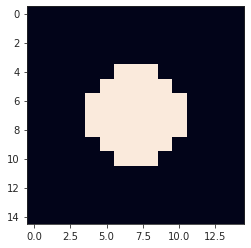

In [75]:
plt.imshow(xi0 ** 2 + yi0 ** 2 <= 49)

## From PY_PROC, return later:

In [2]:
import h5py

base_dir = '/home/hadivafa/Documents/PROJECTS/MT_LFP'
path = os.path.join(base_dir, "synth_hyperflow", "hyperflow.h5")
f = h5py.File(path, 'r')
opticflow = np.array(f["opticflow"], dtype=float)
aperturecenter = np.array(f["aperturecenter"], dtype=float)
stim = np.array(f["stim"], dtype=float)
f.close()

stim = stim.reshape(2, 15, 15, -1)
stim.shape, opticflow.shape, aperturecenter.shape

((2, 15, 15, 2097152), (6, 2097152), (2, 2097152))

In [3]:
import sys
sys.path.insert(0, pjoin(os.environ['HOME'], 'Dropbox/git/MT-VAE'))
from utils.plotting import plot_vel_field

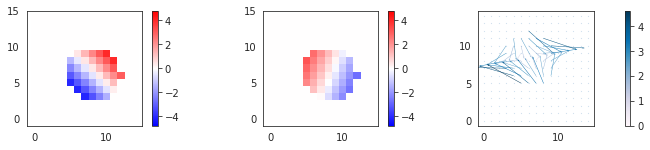

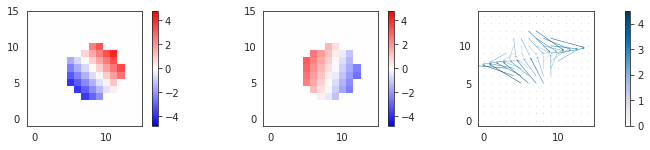

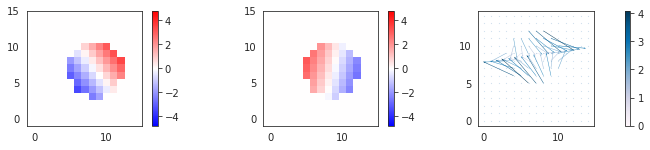

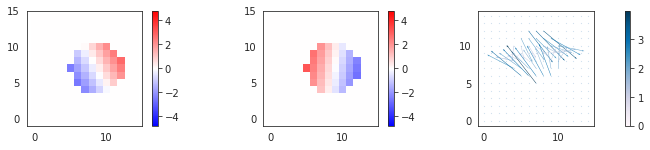

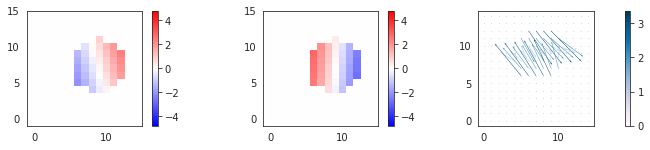

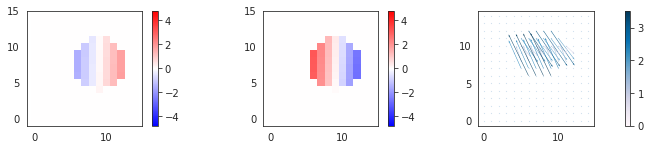

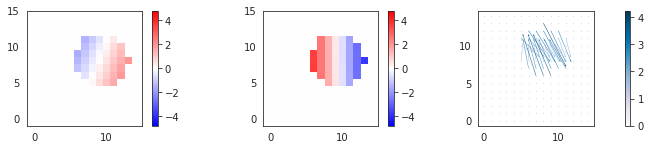

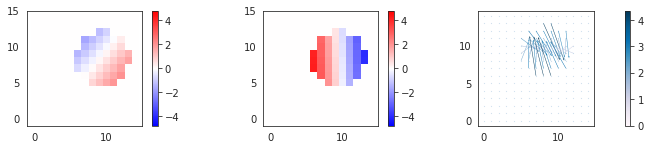

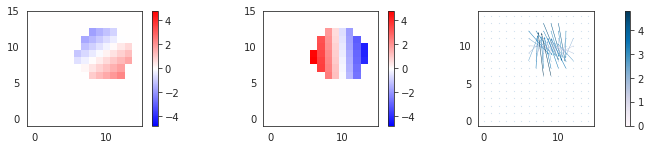

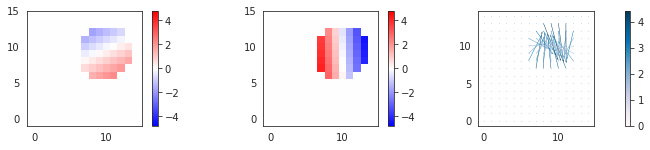

In [4]:
plot_vel_field(stim[..., 1180:1190])